In [15]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import factorial, gamma
from scipy.optimize import fsolve, root, brentq
from sklearn.neighbors import KernelDensity

In [33]:
ns = 14.933117
nb = 38.836
mu = 1.
nobs = 40.

nsim = int(1e6) #number of simulated events
n_max = 2*(ns+nb) #max number of observed events
n_min = 0


t_mu = []

In [17]:
#likelihood function
def likelihood(n, nb, ns, mu):
    '''
    Obtain the Likelihood for a specific set of data
    n : # observed of events
    nb : # of background events
    ns : # of signal events
    mu : strength parameter
    '''
    ntot = nb + mu*ns
    prob = stats.poisson.pmf(n, ntot)
    
    return prob

In [18]:
#test statistics
mu_hat = max((nobs - nb)/ns,0)

L_max = likelihood(nobs, nb, ns, mu_hat)
L_0 = likelihood(nobs, nb, ns, mu)

t_obs = -2*np.log(L_0/L_max)

In [19]:
t_obs

3.87264881789838

<h2>Obtain p-value</h2>
<h3>Method 1: Monte Carlo simulations</h3>

In [20]:
pseudo_n = np.random.poisson(lam=mu*ns+nb, size=nsim) #generate pseudo data

In [22]:
L0 = likelihood(pseudo_n, nb, ns, mu) # obtain likelihood for pseudo data
mu_hat = (pseudo_n - nb)/ns 
mu_hat = mu_hat[mu_hat >= 0]
t_mu = -2*np.log(L0/L_max)

In [30]:
tvals = np.linspace(t_mu.min(),t_mu.max(),150)
# N = len(t_mu)
# w = N*[1/N]

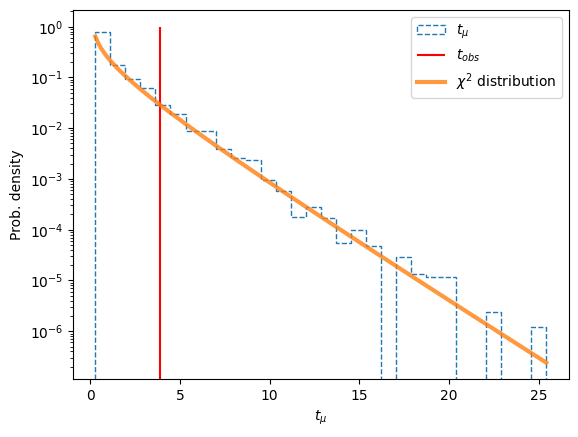

In [29]:
hist, binEdges, patches = plt.hist(t_mu, bins=30, density=True, label=r'$t_{\mu}$',histtype='step', linestyle='--')
plt.vlines(t_obs, 0, 1, 'red', label='$t_{obs}$')
plt.plot(tvals,stats.chi2.pdf(tvals,df=1), label=r'$\chi ^{2}$ distribution',linewidth=3,alpha=0.8)

plt.legend()
plt.ylabel('Prob. density')
plt.xlabel(r'$t_{\mu}$')
plt.yscale('log')
# plt.xlim(0,5)
plt.show()

In [31]:
# Obtain p-value
pval = len(t_mu[t_mu>=t_obs])/len(t_mu)
print(pval)

0.064417


In [26]:
print(hist.sum())

1.1945163350010435


<h3>Method 2: $\chi^{2}_{n}$ Wilks' theorem</h3>

Instead of using a MC generated distribution function, for large data samples, $f(t_{\mu}|\mu) \approx \chi^{2}_{1}(t_{\mu})$, and then, the p-value is given by $p_{\mu} = 1 - F_{\chi^{2}_{1}}(t_{\mu}^{obs}$, i.e., 1 minus the cumulative chi squared distribution function.

In [27]:
p_value = 1 - stats.chi2.cdf(t_obs, 1)
print(p_value)

0.04907900657964037


Now, let us search for the maximum value of $\mu$ that accepts the hypothesis. We adjust $\mu$ until we find a p-value of 0.05. This is the median upper limit of $\mu$ at $95\%$ confidence level.

In [13]:
cl = .95 #confidence level
alpha = 1 - cl #type 1 error
#find the value of the test statistics that yields a p value of 0.05
cdf = lambda t: 1 - stats.chi2.cdf(t, 1) - alpha 
t95 = root(cdf, 0).x
#find mu that yields p value of 0.05
t_func = lambda mu95: -2*np.log(likelihood(nobs, nb, ns, mu95)/L_max) - t95
mu_alpha = float(root(t_func, 1).x)